# Phase profile in directed Human Brain Connectome

In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *

from src import plot_surf
from src import operations
from src import graph_utils
from src import jordanzero_destroy

import h5py
import nibabel as nib
from scipy.io import loadmat

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

## Description

Phase profile in directed human brain connectome

GOAL: Analyse phase profile of of HCP task fMRI

## Table of Contents
- [Phase Profile in fMRI](#phase-profile)

In [2]:
resource_path = '../resources/'
data_path = '/Users/mikichan/Desktop/mywork/atlas_data/'

## Graph Phase profile - Test / Retest

### Loading Graph and Transform

In [3]:
package = utils.load(utils.op.join(resource_path, 'brain_directed_graph/bin_directed_connectome_ftract+structural-d50+metadata.pkl'))
A, roi_atlas, region_labels = package['struct'], package['atlas'], package['regionnames']

nb_nodes = A.shape[0]

L, U, V, Uinv, _, _, _ = graph_utils.prep_transform(A, gso="laplacian")

Lu, Uu, Vu, Uinvu, _, _, _ = graph_utils.prep_transform(((A + A.T) > 0).astype(float), gso="laplacian")

### Preparing Motor/Rest fMRI

In [14]:
tmpvol.shape

(1200, 91, 109, 91)

In [16]:
# LOAD DATA - MOTOR TASK
TR = 0.72
hrf_pad = int(np.round(5/TR))
# list_subjects = ['100307', '100408', '101107', '101309', '101915']
list_subjects = ['100408', '101107', '101309']
# list_subjects = ['100408']
taskparadigms1 = []
taskparadigms2 = []

for subject in list_subjects:
    taskparadigms1.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_LR.mat'))['Regressor'][0][:-hrf_pad])
    taskparadigms2.append(loadmat(op.join(data_path, f'HCP_sample/HCP_taskparadigm_labels/{subject}_Regressor_tfMRI_MOTOR_RL.mat'))['Regressor'][0][:-hrf_pad])
taskparadigms1 = np.concatenate(taskparadigms1)
taskparadigms2 = np.concatenate(taskparadigms2)
ntimepoints = taskparadigms1.shape[-1]

print(f"Number of timepoints = {ntimepoints}")

# HCP task data - atlasing
motor1_roi_timecourses = []
motor2_roi_timecourses = []
atlas_data, affine = roi_atlas.get_fdata(), roi_atlas.affine
for subject in tqdm(list_subjects):
    subpath2volumes = f'HCP_sample/HCP_motor/volume/{subject}/'
    file_list1 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_LR/fMRIvols_GLMyes'))
    reorder_list1 = np.argsort([int(file[-8:-4]) for file in file_list1 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list1 = np.array(file_list1)[reorder_list1]
    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_LR/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list1])[hrf_pad:]

    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s

    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)
    motor1_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))

    file_list2 =  os.listdir(op.join(data_path, subpath2volumes, 'tfMRI_MOTOR_RL/fMRIvols_GLMyes'))
    reorder_list2 = np.argsort([int(file[-8:-4]) for file in file_list2 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list2 = np.array(file_list2)[reorder_list2]

    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'tfMRI_MOTOR_RL/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list2])[hrf_pad:]
    
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)
    motor2_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))
    
motor1_roi_timecourses = np.concatenate(motor1_roi_timecourses, axis=1)
motor2_roi_timecourses = np.concatenate(motor2_roi_timecourses, axis=1)

# LOAD DATA - REST
# list_subjects = ['100307', '100408', '101107', '101309', '101915']

# HCP task data - atlasing
rest1_roi_timecourses = []
rest2_roi_timecourses = []
max_timepoints = 250
for subject in tqdm(list_subjects):
    subpath2volumes = f'HCP_sample/HCP_rest/volume/{subject}/'
    file_list1 =  os.listdir(op.join(data_path, subpath2volumes, 'rfMRI_REST1_LR/fMRIvols_GLMyes'))
    reorder_list1 = np.argsort([int(file[-8:-4]) for file in file_list1 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list1 = np.array(file_list1)[reorder_list1]
    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'rfMRI_REST1_LR/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list1])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s
    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)

    rest1_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))
    
    file_list2 =  os.listdir(op.join(data_path, subpath2volumes, 'rfMRI_REST1_RL/fMRIvols_GLMyes'))
    reorder_list2 = np.argsort([int(file[-8:-4]) for file in file_list2 if file.endswith('.nii') or file.endswith('.nii.gz')])
    file_list2 = np.array(file_list2)[reorder_list2]

    tmpvol = np.array([nib.load(op.join(data_path, subpath2volumes, f'rfMRI_REST1_RL/fMRIvols_GLMyes/{file}')).get_fdata() 
                            for file in file_list2])
    m, s = tmpvol[tmpvol!=0].mean(), tmpvol[tmpvol!=0].std()
    tmpvol[tmpvol!=0] = (tmpvol[tmpvol!=0] - m)/s    

    tmp_roi_timecourses = np.zeros((nb_nodes, tmpvol.shape[0]))
    for k in range(1, nb_nodes + 1):
        tmp_roi_timecourses[k-1] = tmpvol[:, atlas_data == k].mean(axis=1)

    rest2_roi_timecourses.append(zscore(tmp_roi_timecourses, axis=1))
    
rest1_roi_timecourses = np.concatenate(rest1_roi_timecourses, axis=1)
rest2_roi_timecourses = np.concatenate(rest2_roi_timecourses, axis=1)

Number of timepoints = 831


100%|██████████| 3/3 [03:02<00:00, 60.90s/it]


### Results

In [21]:
# graph_fourier_timecourse1 = np.array([operations.GFT(combine1_roi_timecourses[t], U=U, Uinv=Uinv) for t in range(ncombine1_timepoints)])
# graph_fourier_timecourse2 = np.array([operations.GFT(combine2_roi_timecourses[t], U=U, Uinv=Uinv) for t in range(ncombine2_timepoints)])

graph_fourier_timecourse1 = np.array([operations.GFT(motor1_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])
graph_fourier_timecourse2 = np.array([operations.GFT(motor2_roi_timecourses[:, t], U=U, Uinv=Uinv) for t in range(ntimepoints)])

#### Clustering

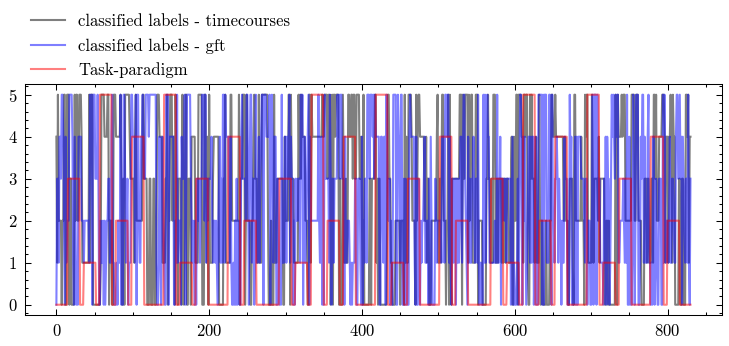

In [22]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 6

polar_gft1 = np.concatenate([zscore(np.abs(graph_fourier_timecourse1), axis=1), 
                             zscore(np.angle(graph_fourier_timecourse1), axis=1)], axis=1)
polar_gft2 = np.concatenate([zscore(np.abs(graph_fourier_timecourse2), axis=1), 
                             zscore(np.angle(graph_fourier_timecourse2), axis=1)], axis=1)

# Perform k-means clustering on graph_fourier_timecourse1
kmeans_gft = KMeans(n_clusters=n_clusters, random_state=0).fit(polar_gft1)
labels_gft = kmeans_gft.labels_

# Perform k-means clustering on motor1_roi_timecourses
kmeans_motor = KMeans(n_clusters=n_clusters, random_state=0).fit(motor1_roi_timecourses.T)
labels_motor = kmeans_motor.labels_

# Print the cluster centers for both
# print("Cluster centers for graph_fourier_timecourse1:\n", kmeans_gft.cluster_centers_)
# print("Labels for graph_fourier_timecourse1:\n", labels_gft)

# print("Cluster centers for motor1_roi_timecourses:\n", kmeans_motor.cluster_centers_)
# print("Labels for motor1_roi_timecourses:\n", labels_motor)
plt.figure(figsize=(6,2))
plt.plot(labels_motor, label='classified labels - timecourses', linestyle='solid', alpha=0.5)
plt.plot(labels_gft, label='classified labels - gft', color='b', linestyle='solid', alpha=0.5)
plt.plot(taskparadigms1, label='Task-paradigm', linestyle='solid', alpha=0.5)
plt.legend(loc=(0,1))

#### Prediction

Using timecourses directly

Train Model accuracy: 81.71%
Test Model accuracy: 49.70%


Text(0.5, 1.0, 'Model Predictions vs True Labels: Test')

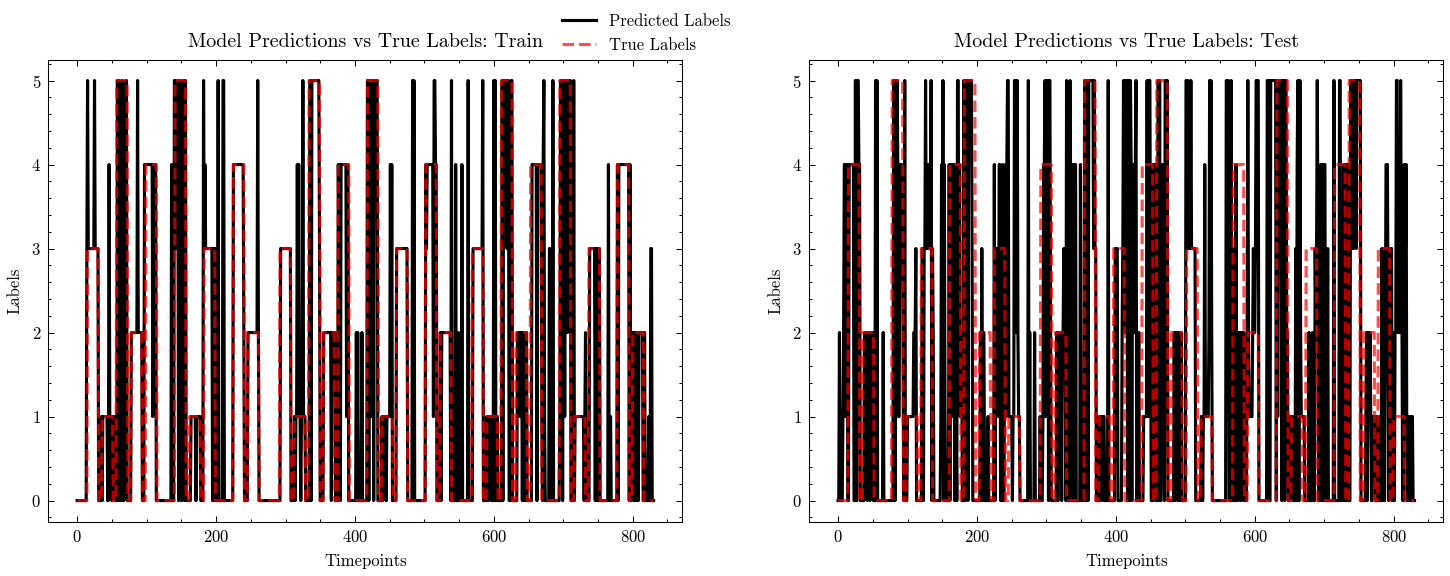

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from joblib import dump

# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline.fit(motor1_roi_timecourses.T, taskparadigms1)
# logreg_pipeline.fit(combine1_roi_timecourses, taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(motor1_roi_timecourses.T)
predicted_labels_logreg_test = logreg_pipeline.predict(motor2_roi_timecourses.T)

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0].plot(taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5, linestyle='--')
ax[0].set_xlabel('Timepoints')
ax[0].set_ylabel('Labels')
ax[0].set_title('Model Predictions vs True Labels: Train')
ax[0].legend(loc=(0.8,1))
ax[1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[1].plot(taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[1].set_xlabel('Timepoints')
ax[1].set_ylabel('Labels')
ax[1].set_title('Model Predictions vs True Labels: Test')

# ax[1,0].plot(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0]))

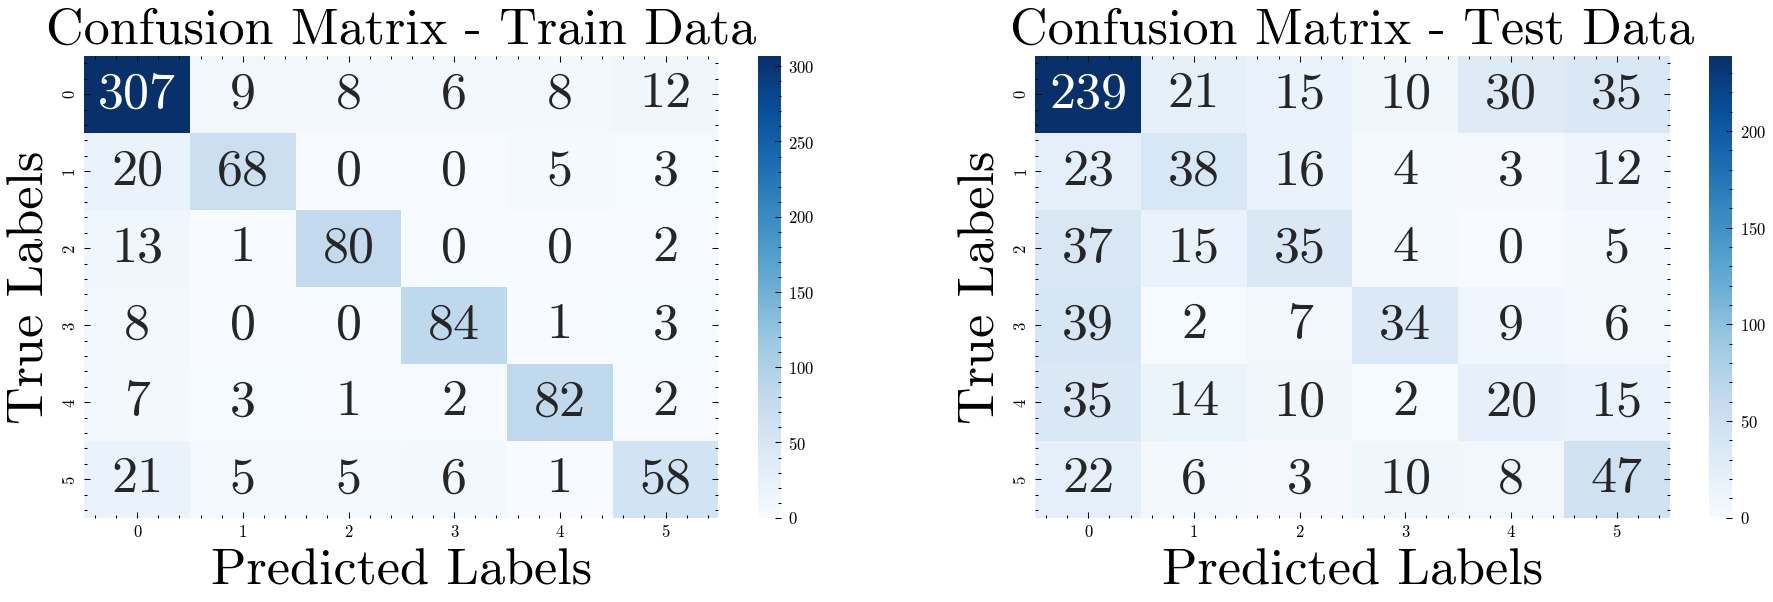

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

paradigms = [taskparadigms1, taskparadigms2]
predictions = [predicted_labels_logreg_train, predicted_labels_logreg_test]
titles = ['Train Data', 'Test Data']
fig,ax = plt.subplots(1,2, figsize=(15,4))

for i in range(2):
    conf_matrix = confusion_matrix(paradigms[i], predictions[i])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 25}, ax=ax[i])
    ax[i].set_title(f'Confusion Matrix - {titles[i]}', size=25)
    ax[i].set_xlabel('Predicted Labels', size=25)
    ax[i].set_ylabel('True Labels', size=25)


Using GFT of timecourses directly

Train Model accuracy: 66.06%
Test Model accuracy: 33.69%


Text(0.5, 1.0, 'Model Predictions vs True Labels: Test')

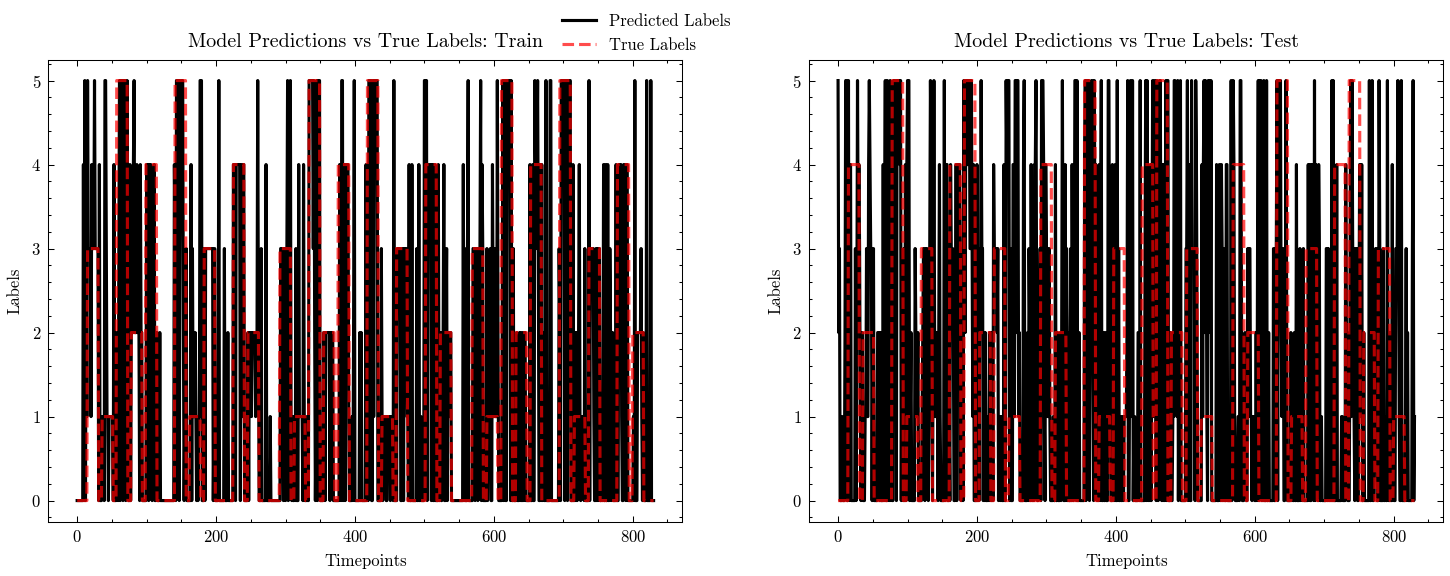

In [25]:
# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
# logreg_pipeline.fit(np.concatenate((graph_fourier_timecourse1.real, graph_fourier_timecourse1.imag), axis=1), taskparadigms1)
logreg_pipeline.fit(np.concatenate((zscore(np.abs(graph_fourier_timecourse1), axis=1), 
                                    zscore(np.angle(graph_fourier_timecourse1), axis=1)), axis=1), taskparadigms1)



# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
# predicted_labels_logreg_train = logreg_pipeline.predict(np.concatenate((graph_fourier_timecourse1.real, graph_fourier_timecourse1.imag), axis=1))
# predicted_labels_logreg_test = logreg_pipeline.predict(np.concatenate((graph_fourier_timecourse2.real, graph_fourier_timecourse2.imag), axis=1))

predicted_labels_logreg_train = logreg_pipeline.predict(np.concatenate((zscore(np.abs(graph_fourier_timecourse1), axis=1), 
                                                                        zscore(np.angle(graph_fourier_timecourse1), axis=1)), axis=1))
predicted_labels_logreg_test = logreg_pipeline.predict(np.concatenate((zscore(np.abs(graph_fourier_timecourse2), axis=1), 
                                                                       zscore(np.angle(graph_fourier_timecourse2), axis=1)), axis=1))

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0].plot(taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5, linestyle='--')
ax[0].set_xlabel('Timepoints')
ax[0].set_ylabel('Labels')
ax[0].set_title('Model Predictions vs True Labels: Train')
ax[0].legend(loc=(0.8,1))
ax[1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[1].plot(taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[1].set_xlabel('Timepoints')
ax[1].set_ylabel('Labels')
ax[1].set_title('Model Predictions vs True Labels: Test')

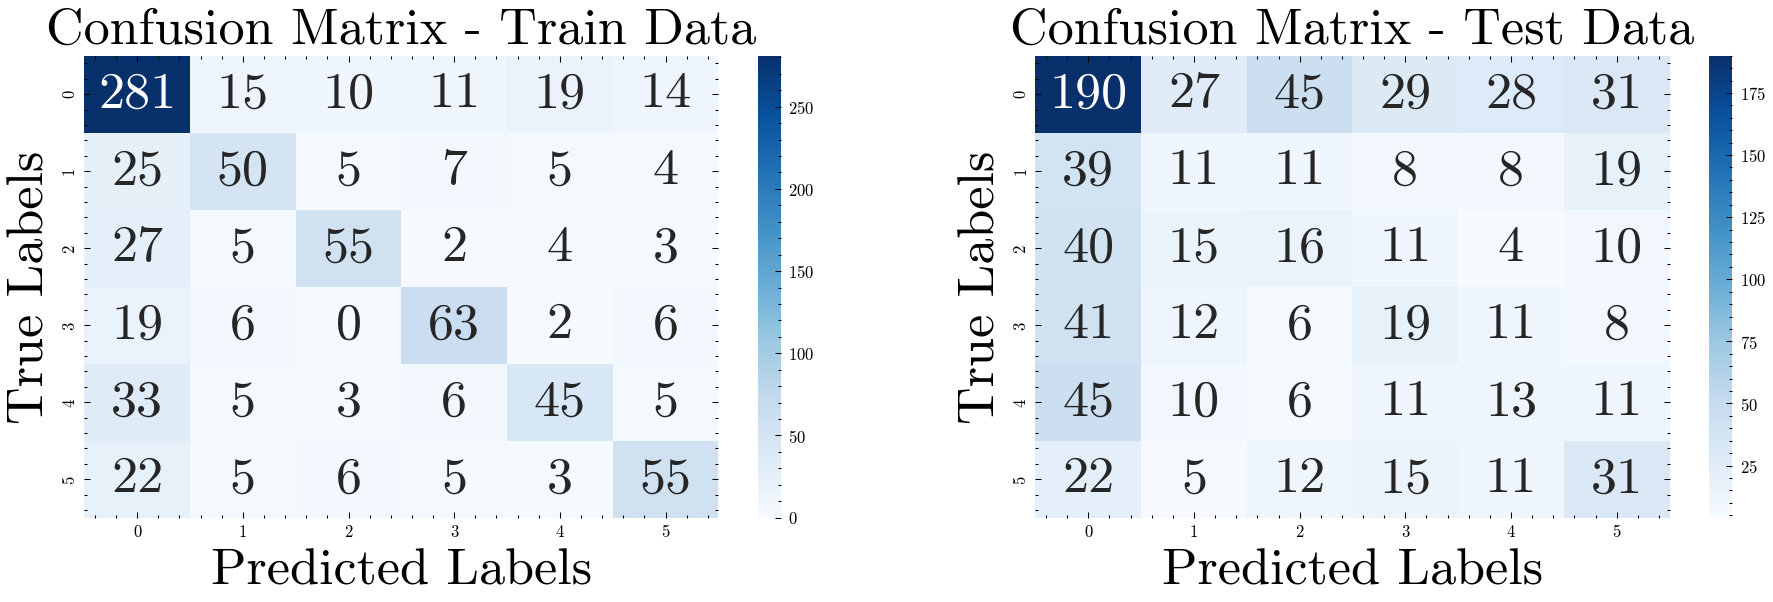

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

paradigms = [taskparadigms1, taskparadigms2]
predictions = [predicted_labels_logreg_train, predicted_labels_logreg_test]
titles = ['Train Data', 'Test Data']
fig,ax = plt.subplots(1,2, figsize=(15,4))

for i in range(2):
    conf_matrix = confusion_matrix(paradigms[i], predictions[i])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 25}, ax=ax[i])
    ax[i].set_title(f'Confusion Matrix - {titles[i]}', size=25)
    ax[i].set_xlabel('Predicted Labels', size=25)
    ax[i].set_ylabel('True Labels', size=25)

#### Predicting Motor versus Rest
Allow shuffling since we don't rely on temporal information

In [27]:
combine1_roi_timecourses = np.concatenate([motor1_roi_timecourses.T, rest1_roi_timecourses.T])
combine1_roi_timecourses = combine1_roi_timecourses[:taskparadigms1.shape[0]*2]
combine1_roi_timecourses = zscore(combine1_roi_timecourses)
ncombine1_timepoints = combine1_roi_timecourses.shape[0]

combine2_roi_timecourses = np.concatenate([motor2_roi_timecourses.T, rest2_roi_timecourses.T])
combine2_roi_timecourses = combine2_roi_timecourses[:taskparadigms2.shape[0]*2]
combine2_roi_timecourses = zscore(combine2_roi_timecourses)
ncombine2_timepoints = combine2_roi_timecourses.shape[0]

combine_graph_fourier_timecourse1 = np.array([operations.GFT(combine1_roi_timecourses[t], U=U, Uinv=Uinv) for t in range(ncombine1_timepoints)])
combine_graph_fourier_timecourse2 = np.array([operations.GFT(combine2_roi_timecourses[t], U=U, Uinv=Uinv) for t in range(ncombine2_timepoints)])

In [28]:
# combine_taskparadigms1 = np.concatenate([taskparadigms1, -np.ones(taskparadigms1.shape)])
# combine_taskparadigms2 = np.concatenate([taskparadigms2, -np.ones(taskparadigms2.shape)])

combine_taskparadigms1 = np.concatenate([taskparadigms1, np.zeros(taskparadigms1.shape)])
combine_taskparadigms2 = np.concatenate([taskparadigms2, np.zeros(taskparadigms2.shape)])

Train Model accuracy: 87.97%
Test Model accuracy: 73.41%


Text(0.5, 1.0, 'Model Predictions vs True Labels: Test')

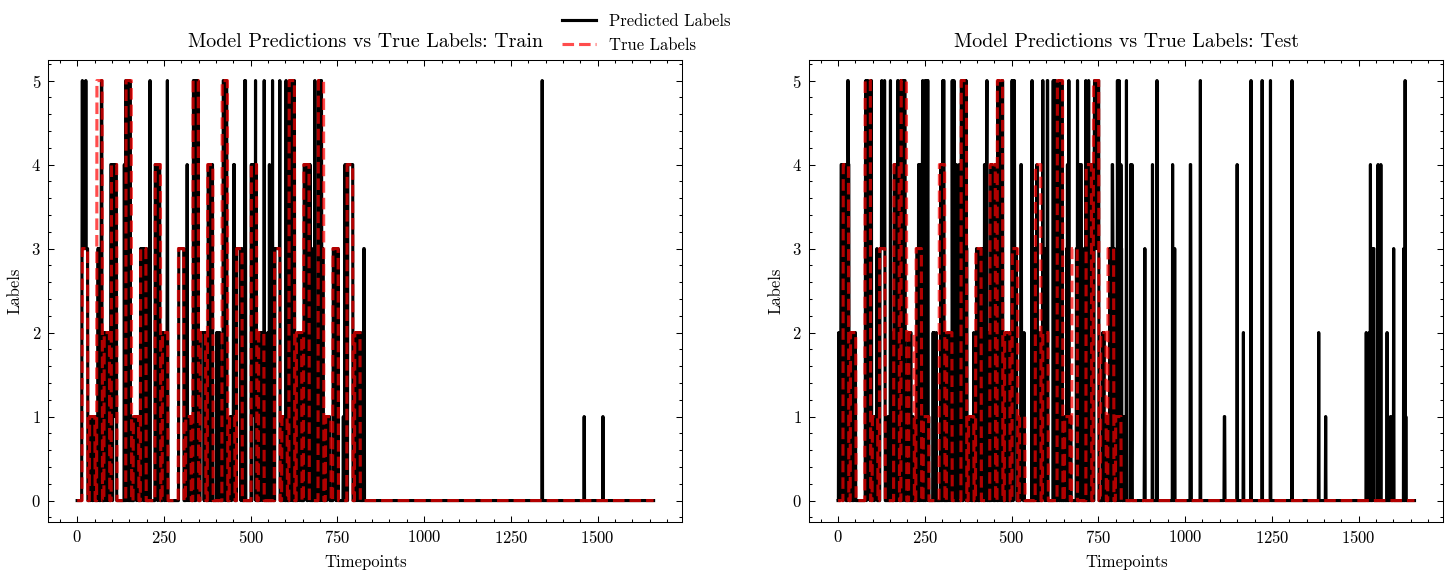

In [29]:
# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline.fit(combine1_roi_timecourses, combine_taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(combine1_roi_timecourses)
predicted_labels_logreg_test = logreg_pipeline.predict(combine2_roi_timecourses)

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == combine_taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == combine_taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0].plot(combine_taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5, linestyle='--')
ax[0].set_xlabel('Timepoints')
ax[0].set_ylabel('Labels')
ax[0].set_title('Model Predictions vs True Labels: Train')
ax[0].legend(loc=(0.8,1))
ax[1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[1].plot(combine_taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[1].set_xlabel('Timepoints')
ax[1].set_ylabel('Labels')
ax[1].set_title('Model Predictions vs True Labels: Test')

# ax[1,0].plot(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0]))

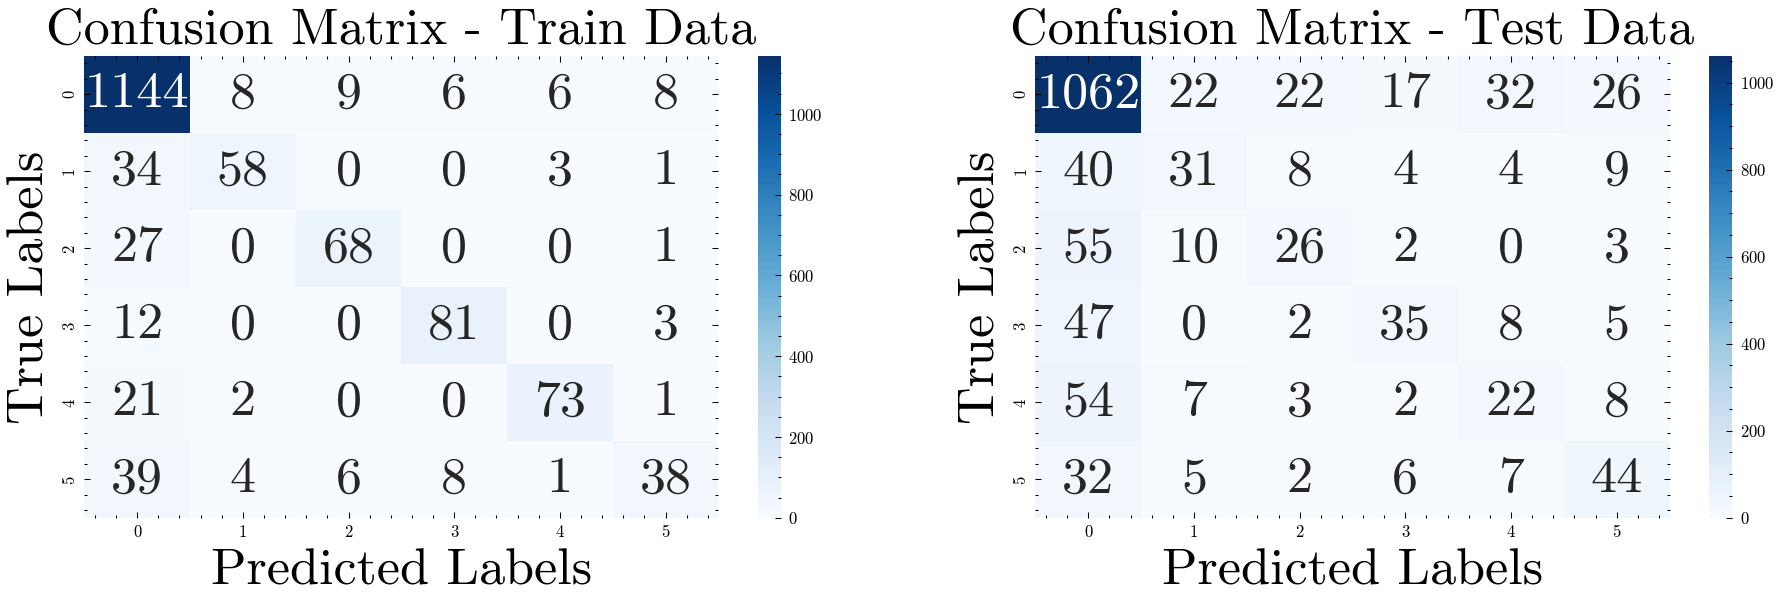

In [30]:
paradigms = [combine_taskparadigms1,combine_taskparadigms2]
predictions = [predicted_labels_logreg_train, predicted_labels_logreg_test]
titles = ['Train Data', 'Test Data']
fig,ax = plt.subplots(1,2, figsize=(15,4))

for i in range(2):
    conf_matrix = confusion_matrix(paradigms[i], predictions[i])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 25}, ax=ax[i])
    ax[i].set_title(f'Confusion Matrix - {titles[i]}', size=25)
    ax[i].set_xlabel('Predicted Labels', size=25)
    ax[i].set_ylabel('True Labels', size=25)


With GFT as metrics instead

Train Model accuracy: 86.82%
Test Model accuracy: 73.47%


Text(0.5, 1.0, 'Model Predictions vs True Labels: Test')

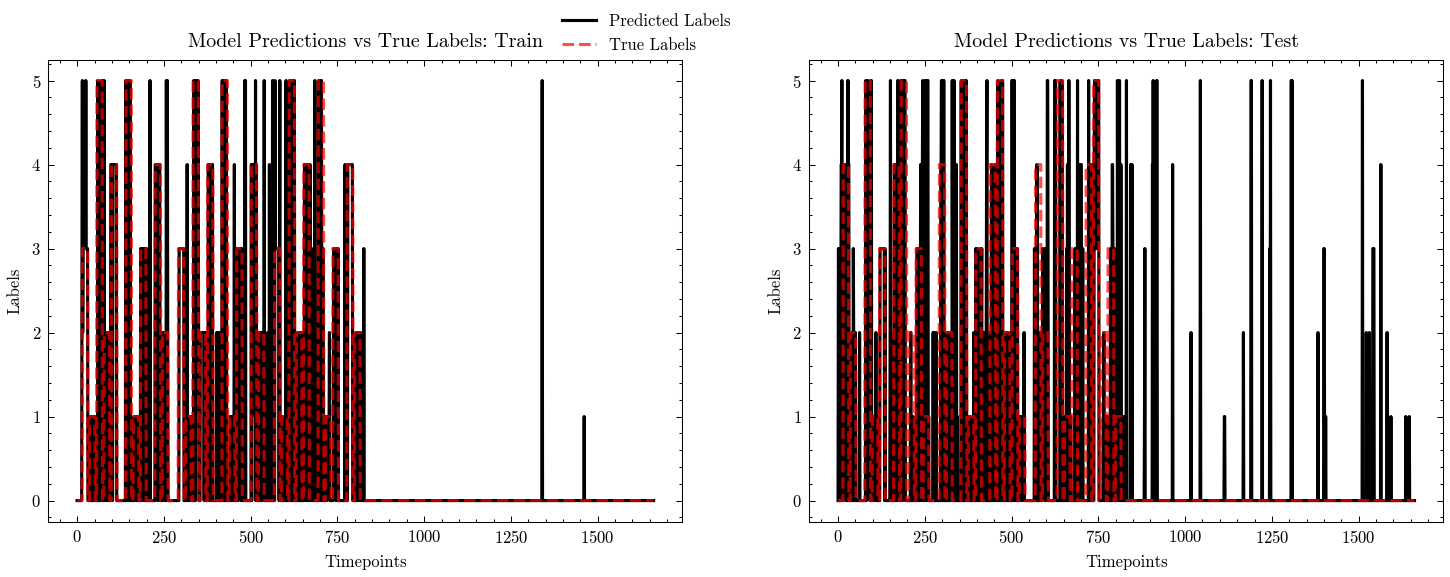

In [31]:
# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
# logreg_pipeline.fit(combine_graph_fourier_timecourse1, combine_taskparadigms1)
logreg_pipeline.fit(np.concatenate((combine_graph_fourier_timecourse1.real, combine_graph_fourier_timecourse1.imag), axis=1), combine_taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(np.concatenate((combine_graph_fourier_timecourse1.real, combine_graph_fourier_timecourse1.imag), axis=1))
predicted_labels_logreg_test = logreg_pipeline.predict(np.concatenate((combine_graph_fourier_timecourse2.real, combine_graph_fourier_timecourse2.imag), axis=1))

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == combine_taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == combine_taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0].plot(combine_taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5, linestyle='--')
ax[0].set_xlabel('Timepoints')
ax[0].set_ylabel('Labels')
ax[0].set_title('Model Predictions vs True Labels: Train')
ax[0].legend(loc=(0.8,1))
ax[1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[1].plot(combine_taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[1].set_xlabel('Timepoints')
ax[1].set_ylabel('Labels')
ax[1].set_title('Model Predictions vs True Labels: Test')

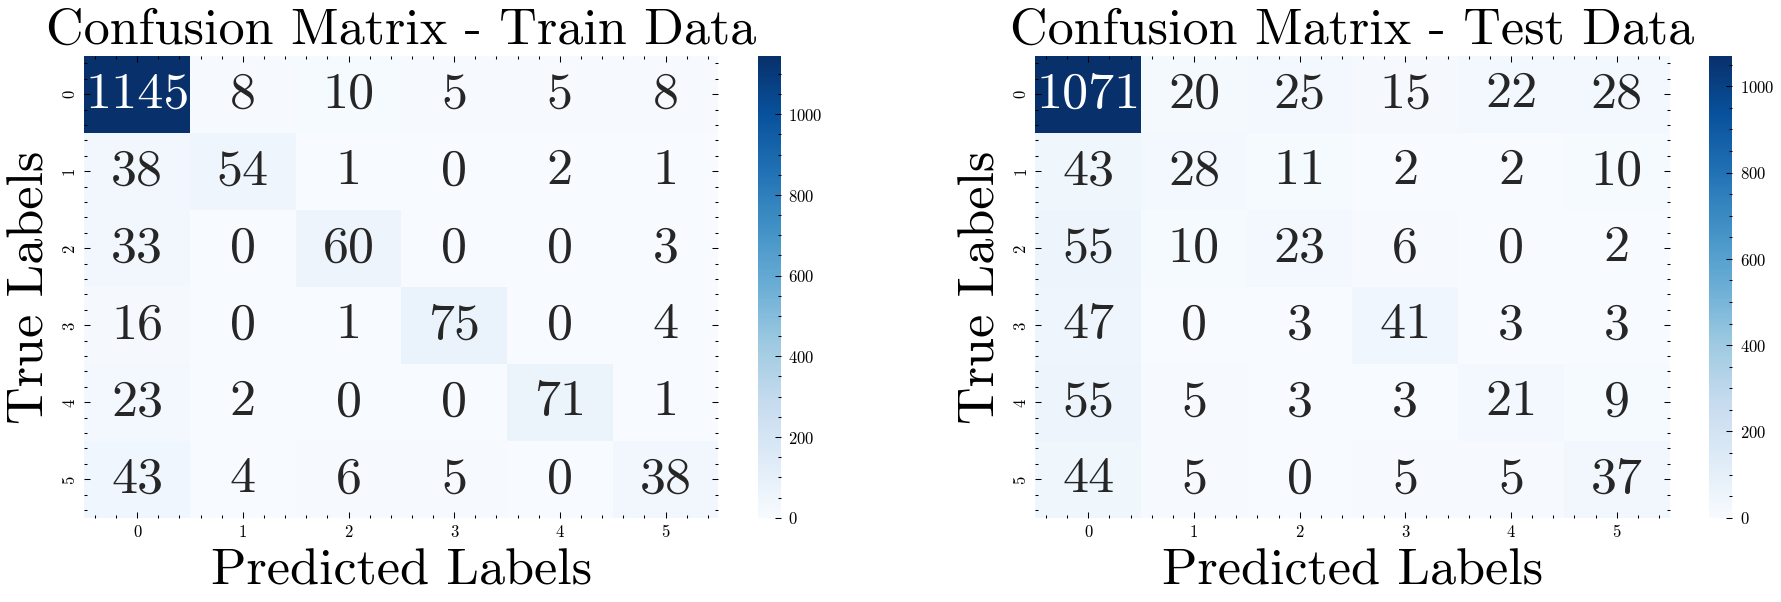

In [32]:
paradigms = [combine_taskparadigms1,combine_taskparadigms2]
predictions = [predicted_labels_logreg_train, predicted_labels_logreg_test]
titles = ['Train Data', 'Test Data']
fig,ax = plt.subplots(1,2, figsize=(15,4))

for i in range(2):
    conf_matrix = confusion_matrix(paradigms[i], predictions[i])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 25}, ax=ax[i])
    ax[i].set_title(f'Confusion Matrix - {titles[i]}', size=25)
    ax[i].set_xlabel('Predicted Labels', size=25)
    ax[i].set_ylabel('True Labels', size=25)

Frequencies of importance across all labels

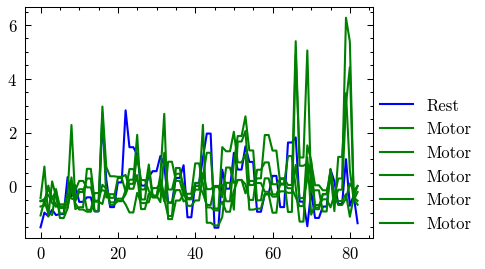

In [33]:
# Plot the obtained frequencies or apparent important features as histograms
def mergeback_freq(coefs, N):
    return coefs[:N] + coefs[N:]

colors = ['b', 'g']
for k in range(6):
    if k == 0:
        plt.plot(zscore(mergeback_freq(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[k]), nb_nodes)), 
                 label=f'Rest', color=colors[0])
    else:
        plt.plot(zscore(mergeback_freq(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[k]), nb_nodes)), 
                 label=f'Motor', color=colors[1], linestyle='solid')
plt.legend(loc=(1,0))
plt.show()

#### Predicting Motor vs Rest with two categories only

In [34]:
combine1_roi_timecourses = np.concatenate([motor1_roi_timecourses.T, rest1_roi_timecourses.T])
combine1_roi_timecourses = combine1_roi_timecourses[:taskparadigms1.shape[0]*2]
combine1_roi_timecourses = zscore(combine1_roi_timecourses)
ncombine1_timepoints = combine1_roi_timecourses.shape[0]

combine2_roi_timecourses = np.concatenate([motor2_roi_timecourses.T, rest2_roi_timecourses.T])
combine2_roi_timecourses = combine2_roi_timecourses[:taskparadigms2.shape[0]*2]
combine2_roi_timecourses = zscore(combine2_roi_timecourses)
ncombine2_timepoints = combine2_roi_timecourses.shape[0]

combine_graph_fourier_timecourse1 = np.array([operations.GFT(combine1_roi_timecourses[t], U=U, Uinv=Uinv) for t in range(ncombine1_timepoints)])
combine_graph_fourier_timecourse2 = np.array([operations.GFT(combine2_roi_timecourses[t], U=U, Uinv=Uinv) for t in range(ncombine2_timepoints)])

In [35]:
masking1 = np.concatenate([taskparadigms1, np.ones_like(taskparadigms1)]) != 0
masking2 = np.concatenate([taskparadigms2, np.ones_like(taskparadigms2)]) != 0
bin_taskparadigms1 = np.concatenate([np.ones_like(taskparadigms1), np.zeros(taskparadigms1.shape)])
bin_taskparadigms2 = np.concatenate([np.ones_like(taskparadigms2), np.zeros(taskparadigms2.shape)])
bin_taskparadigms1 = bin_taskparadigms1[masking1]
bin_taskparadigms2 = bin_taskparadigms2[masking2]

Train Model accuracy: 75.30%
Test Model accuracy: 69.36%


Text(0.5, 0.98, 'Timecourse Based')

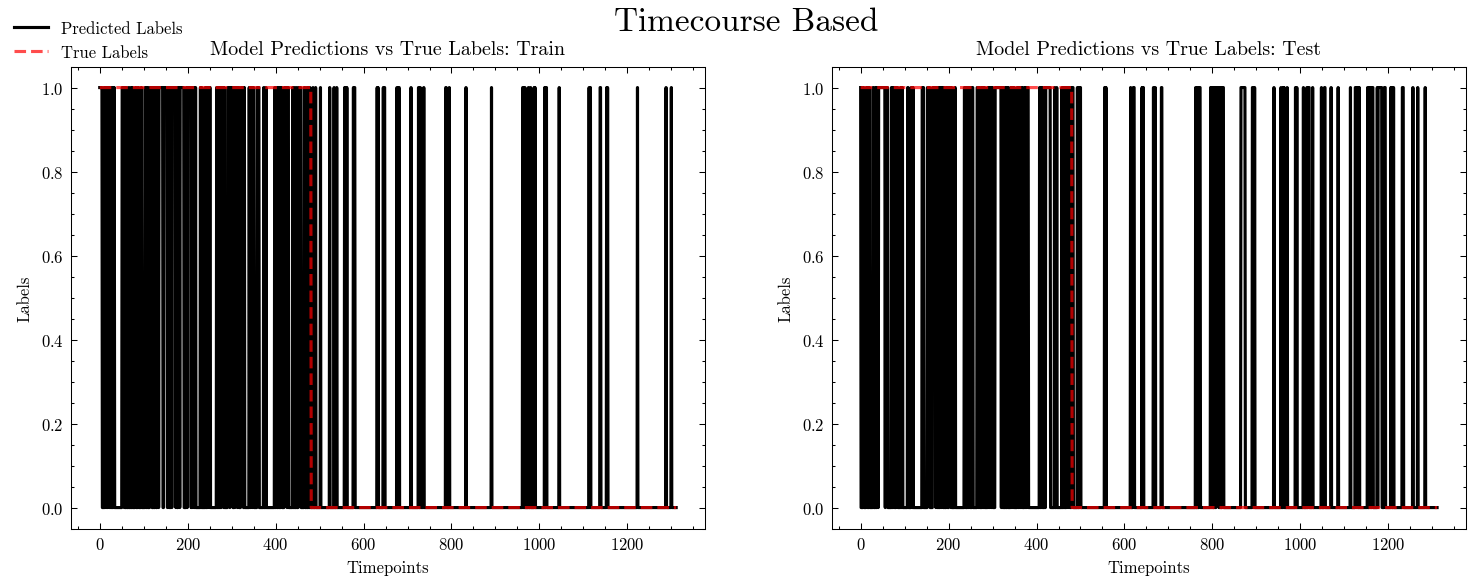

In [36]:
# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_pipeline.fit(combine1_roi_timecourses[masking1], bin_taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(combine1_roi_timecourses[masking1])
predicted_labels_logreg_test = logreg_pipeline.predict(combine2_roi_timecourses[masking2])

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == bin_taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == bin_taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0].plot(bin_taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5, linestyle='--')
ax[0].set_xlabel('Timepoints')
ax[0].set_ylabel('Labels')
ax[0].set_title('Model Predictions vs True Labels: Train')
ax[0].legend(loc=(-0.1,1))
ax[1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[1].plot(bin_taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[1].set_xlabel('Timepoints')
ax[1].set_ylabel('Labels')
ax[1].set_title('Model Predictions vs True Labels: Test')

fig.suptitle('Timecourse Based', fontsize=16)
# ax[1,0].plot(np.abs(logreg_pipeline.named_steps['logisticregression'].coef_[0]))

Train Model accuracy: 75.08%
Test Model accuracy: 69.82%


Text(0.5, 0.98, 'GFT Based')

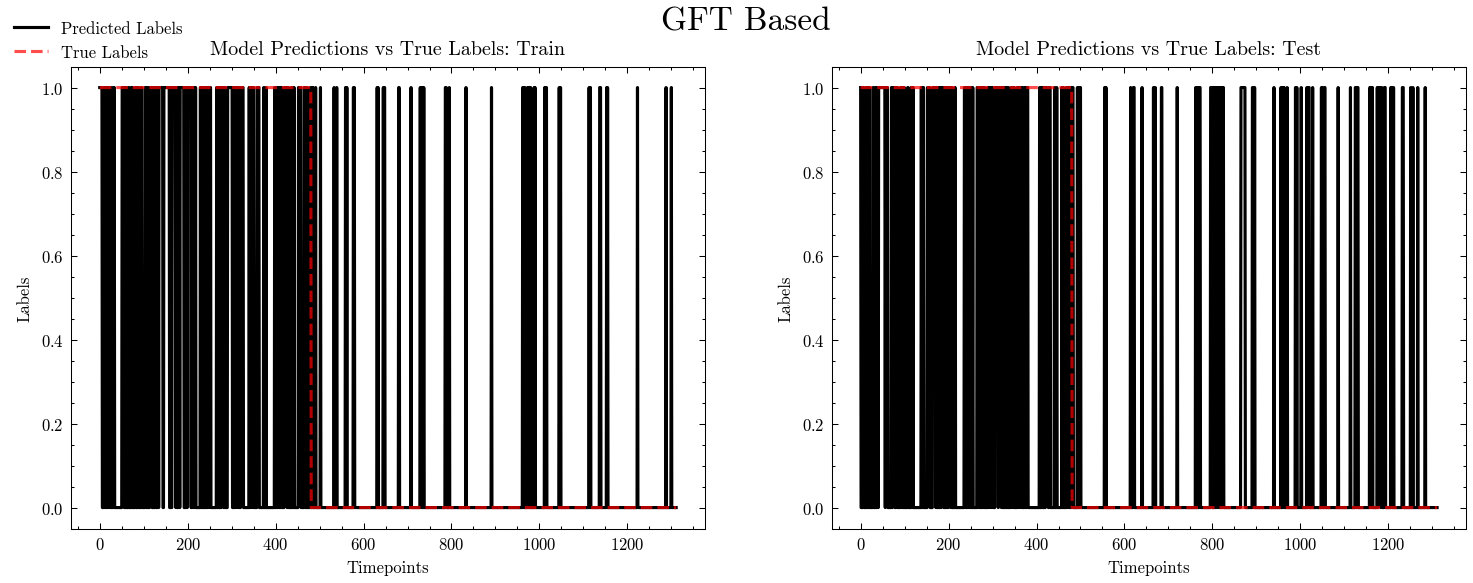

In [37]:
# Create a pipeline with a standard scaler and logistic regression classifier
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
# logreg_pipeline.fit(combine_graph_fourier_timecourse1, combine_taskparadigms1)
logreg_pipeline.fit(np.concatenate((combine_graph_fourier_timecourse1.real[masking1], 
                                    combine_graph_fourier_timecourse1.imag[masking1]), axis=1), 
                                    bin_taskparadigms1)

# Extract the logistic regression weights (coefficients)
logreg_weights = logreg_pipeline.named_steps['logisticregression'].coef_
# Predict the labels for the training data
predicted_labels_logreg_train = logreg_pipeline.predict(np.concatenate((combine_graph_fourier_timecourse1.real[masking1], 
                                                                        combine_graph_fourier_timecourse1.imag[masking1]), axis=1))
predicted_labels_logreg_test = logreg_pipeline.predict(np.concatenate((combine_graph_fourier_timecourse2.real[masking2], 
                                                                       combine_graph_fourier_timecourse2.imag[masking2]), axis=1))

# Calculate the accuracy
accuracy_logreg_train = np.mean(predicted_labels_logreg_train == bin_taskparadigms1)
accuracy_logreg_test = np.mean(predicted_labels_logreg_test == bin_taskparadigms2)
print(f"Train Model accuracy: {accuracy_logreg_train * 100:.2f}%")
print(f"Test Model accuracy: {accuracy_logreg_test * 100:.2f}%")

# Plot the accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(predicted_labels_logreg_train, label='Predicted Labels', linewidth=1.5)
ax[0].plot(bin_taskparadigms1, label='True Labels', alpha=0.7, linewidth=1.5, linestyle='--')
ax[0].set_xlabel('Timepoints')
ax[0].set_ylabel('Labels')
ax[0].set_title('Model Predictions vs True Labels: Train')
ax[0].legend(loc=(-.1,1))
ax[1].plot(predicted_labels_logreg_test, label='Predicted Labels', linewidth=1.5)
ax[1].plot(bin_taskparadigms2, label='True Labels', alpha=0.7, linewidth=1.5)
ax[1].set_xlabel('Timepoints')
ax[1].set_ylabel('Labels')
ax[1].set_title('Model Predictions vs True Labels: Test')

fig.suptitle('GFT Based', fontsize=16)

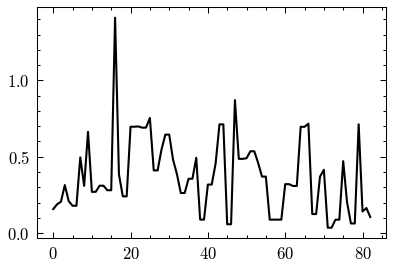

In [38]:
plt.plot(mergeback_freq(np.abs(logreg_weights[0]), nb_nodes))